In [1]:
#Configuro el Google Colab conectandome a los datos desde la cuenta de Google
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
import time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning



# Desactivar las advertencias de convergencia para mejorar la legibilidad
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Preparación de los datos

In [3]:
df1 = pd.read_csv('/content/gdrive/MyDrive/EAFIT/ProyectoIntegrador1/DatasetsRM/csv/df_familias_filtrado.csv') #dataframe etiquetado por k-means
df2 = pd.read_csv('/content/gdrive/MyDrive/EAFIT/ProyectoIntegrador1/DatasetsRM/csv/all_files_E(2).csv') #Dataframe original Inicial, empleado en RAW

# Fusión de dataframes

## Split de columnas

In [4]:
#Split de columna familia en columnas categóricas
df1['family'] = df1['family'].str.split('_')
# Añadir las nuevas columnas al DataFrame original df1
df1[['group_number', 'stator_kv', 'mfr', 'requested_test_kv']] = pd.DataFrame(df1['family'].tolist(), index=df1.index) #creación de columnas categorías
# Eliminar la columna original si es necesario
df1 = df1.drop(columns=['family']) #Se elimina la columna family
df1 = df1.drop(columns=['Unnamed: 0'])#Se elimina columna innecesaria
#df1.to_csv('D:/Analitica/Modelos/Finales/out/df_family_split.csv') # Dataset etiquetado, con columnas separadas a Trusted
#Convertir formato de las columnas
columns_to_convert = ['test_kv', 'ma', 'requested_test_kv']
df1_clean = df1.copy() # Se trabajará con dataframe limpio, para no modificar el original df1
df1_clean[columns_to_convert] = df1_clean[columns_to_convert].astype(float)

## Etiquetado del dataframe original

In [5]:
#Redefinicion de variables; Se volverán a concatenar en 1 sola columna (clave), para mantener un orden lógico de formación
df1_1= df1_clean
df1_1['clave'] = df1['stator_kv'].astype(str) + '_' + df1['mfr'].astype(str) + '_' + df1['group_number'].astype(str)+ '_' + df1['test_kv'].astype(str)+ '_' + df1['ma'].astype(str)
#df1_1.head()

In [6]:
#Redefinicion de variables; Se volverán a concatenar en 1 sola columna (clave), para mantener un orden lógico de formación
df2_2 =df2
df2_2 = df2_2.drop(columns=['Unnamed: 0'])
df2_2['clave'] = df2_2['stator_kv'].astype(str) + '_' + df2_2['mfr'].astype(str) + '_' + df2['group_number'].astype(str)+ '_' + df2_2['test_kv'].astype(str)+ '_' + df2_2['ma'].astype(str)
#df2_2.head(5)

In [7]:
# Contar NaN en df1_1
nan_count_df1_1= df1_1.isna().sum()
# Contar NaN en df2_2
nan_count_df2_2 = df2_2.isna().sum()
print("Conteo de NaN en df1_1:")
print(nan_count_df1_1)
print("\nConteo de NaN en df2_2:")
print(nan_count_df2_2)

Conteo de NaN en df1_1:
test_kv              0
ma                   0
qual                 0
group_number         0
stator_kv            0
mfr                  0
requested_test_kv    0
clave                0
dtype: int64

Conteo de NaN en df2_2:
serial               0
fecha                0
stator_kv            0
mfr                  0
group_number         0
requested_test_kv    0
test_kv              0
ma                   0
watts                0
measured_cap         2
pfm                  0
clave                0
dtype: int64


In [8]:
df2_2 = df2_2.dropna()
#Contar NaN en df2
nan_count_df2_2 = df2_2.isna().sum()
print("\nConteo de NaN en df2:")
print(nan_count_df2_2)


Conteo de NaN en df2:
serial               0
fecha                0
stator_kv            0
mfr                  0
group_number         0
requested_test_kv    0
test_kv              0
ma                   0
watts                0
measured_cap         0
pfm                  0
clave                0
dtype: int64


In [9]:
#Inicializacion de dataframe con dataset original + eqtiquetas de df2
df3 =[]
#df3
# Fusionar df2 con df1 para obtener las etiquetas de entrenamiento en df3 en la columna 'clave'
df3 = pd.merge(df2_2, df1_1[['clave', 'qual']], on='clave', how='left')

In [10]:
# Contar NaN en df3
nan_count_df3 = df3.isna().sum()
# Eliminar filas con NaN en df3
df3 = df3.dropna()


Conteo de NaN en df3:
serial                  0
fecha                   0
stator_kv               0
mfr                     0
group_number            0
requested_test_kv       0
test_kv                 0
ma                      0
watts                   0
measured_cap            0
pfm                     0
clave                   0
qual                 2445
dtype: int64


## Salida de dataframe etiquetado a dataset *.csv

In [12]:
df3.info()

,stator_kv,requested_test_kv,test_kv,ma,watts,measured_cap,pfm,qual
count,55100.000000,55100.000000,55100.000000,55100.000000,55100.000000,55100.000000,55100.000000,55100.000000
mean,12.888849,4.649437,4.649947,783.782292,122.534820,207721.109224,1.713933,1.540181
std,2.335989,2.282029,2.282420,964.307583,178.992006,255885.630611,4.268440,1.037720
min,6.900000,1.000000,0.993000,3.885000,-439.750000,-109771.000000,-92.160000,0.000000
25%,13.800000,2.000000,2.001000,11.600405,0.711000,3070.820043,0.680000,1.000000
50%,13.800000,4.000000,4.002000,154.320000,27.662000,40443.200000,1.160000,2.000000
75%,13.800000,6.000000,6.005000,1416.900000,170.740000,375929.658958,1.950000,2.000000
max,13.800000,10.000000,10.017000,3769.100000,1063.900000,999821.900000,97.821735,3.000000


In [13]:
# Eliminar las columnas utilizadas en el proceso no supervisado, paso necesario para evitar sesgar el modelo
# Dado el planteamiento del problema y que en algunos casos la variable pfm no está disponible, también se excluye del análisis
df3_cleaned = df3.drop(['requested_test_kv', 'test_kv', 'ma', 'watts','pfm'], axis=1)

In [14]:
df3_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55100 entries, 0 to 57544
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   serial        55100 non-null  object 
 1   fecha         55100 non-null  object 
 2   stator_kv     55100 non-null  float64
 3   mfr           55100 non-null  object 
 4   group_number  55100 non-null  object 
 5   measured_cap  55100 non-null  float64
 6   clave         55100 non-null  object 
 7   qual          55100 non-null  float64
dtypes: float64(3), object(5)
memory usage: 3.8+ MB


In [15]:
# Suponiendo que 'df3_cleaned' es tu DataFrame
df3_cleaned.to_csv('df3_cleaned.csv', index=False)

# Preprocesamiento de Datos para Modelado Supervisado

In [18]:
# Seleccionar las variables predictoras (X) y la variable objetivo (y)
X = df3_cleaned.drop('qual', axis=1)
y = df3_cleaned['qual']

# Identificar las características numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Definir transformaciones para las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores faltantes usando la mediana
    ('scaler', StandardScaler())  # Estandarizar los valores numéricos para que tengan media cero y varianza unitaria
])

# Definir transformaciones para las características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Imputar valores faltantes con 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variables categóricas con One-Hot Encoding
])

# Combinar las transformaciones en un preprocesador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Aplicar transformaciones numéricas
        ('cat', categorical_transformer, categorical_features)  # Aplicar transformaciones categóricas
])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Imprimir mensaje indicando que los datos están listos para el modelado
"Datos preparados y listos para el modelado."

'Datos preparados y listos para el modelado.'

In [19]:
# Definir los modelos a utilizar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
}


#Función de entrenamiento y evaluación de los modelos


In [20]:
def train_and_evaluate_model(model_name, X_train, X_test, y_train, y_test):
    if model_name not in models:
        print(f"Modelo '{model_name}' no encontrado.")
        return

    model = models[model_name]
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Ajustar el preprocesador y transformar los datos de entrenamiento y prueba
    X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
    X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

    # Entrenar y obtener probabilidades de clase (si está disponible)
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_transformed, y_train)
        y_pred_probabilities = model.predict_proba(X_test_transformed)
    else:
        # Si no hay predict_proba, utilizar predicciones directas
        model.fit(X_train_transformed, y_train)
        y_pred_probabilities = model.predict(X_test_transformed)

    # Predecir las clases
    y_pred = model.predict(X_test_transformed)

    report = classification_report(y_test, y_pred)

    print(f"Resultados para {model_name}:\n{report}\n")

    # Calcular el AUC si el modelo devuelve probabilidades
    if hasattr(model, 'predict_proba'):
        auc = roc_auc_score(y_test, y_pred_probabilities, multi_class='ovr')
        print(f"AUC para el clasificador {model_name}: {auc}\n")

    # Evaluar el modelo utilizando K-fold cross-validation
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_results)
    print(f"Accuracy promedio en K-fold cross-validation: {mean_cv_accuracy}\n")

    return y_pred, X_test_transformed, report, mean_cv_accuracy

#Función para graficar la curva ROC en un modelo Multiclase

In [21]:
def plot_roc_curve_multiclass_from_probabilities(y_true, y_pred_probabilities):
    # Convertir las etiquetas a su representación numérica
    y_true_numeric = label_binarize(y_true, classes=np.unique(y_true))

    # Inicializar el diccionario para almacenar las tasas de falsos positivos y verdaderos positivos
    fpr_dict = {}
    tpr_dict = {}
    auc_dict = {}

    # Obtener el número de clases
    n_classes = y_true_numeric.shape[1]

    # Calcular las tasas de falsos positivos y verdaderos positivos para cada clase
    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_numeric[:, i], y_pred_probabilities[:, i])
        auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    # Calcular el micro promedio de ROC-AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_numeric.ravel(), y_pred_probabilities.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)

    # Calcular el macro promedio de ROC-AUC
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    auc_macro = auc(fpr_macro, tpr_macro)

    # Plotear la curva ROC para cada clase
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (AUC = {auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr_dict[i], tpr_dict[i], label=f'Class {i} (AUC = {auc_dict[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

Resultados para Support Vector Machine:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.91      3158
         1.0       0.94      0.94      0.94      5024
         2.0       0.91      0.97      0.94      4624
         3.0       0.97      0.94      0.95      3724

    accuracy                           0.94     16530
   macro avg       0.94      0.93      0.93     16530
weighted avg       0.94      0.94      0.94     16530


AUC para el clasificador Support Vector Machine: 0.9953725319391739

Accuracy promedio en K-fold cross-validation: 0.883795696136894



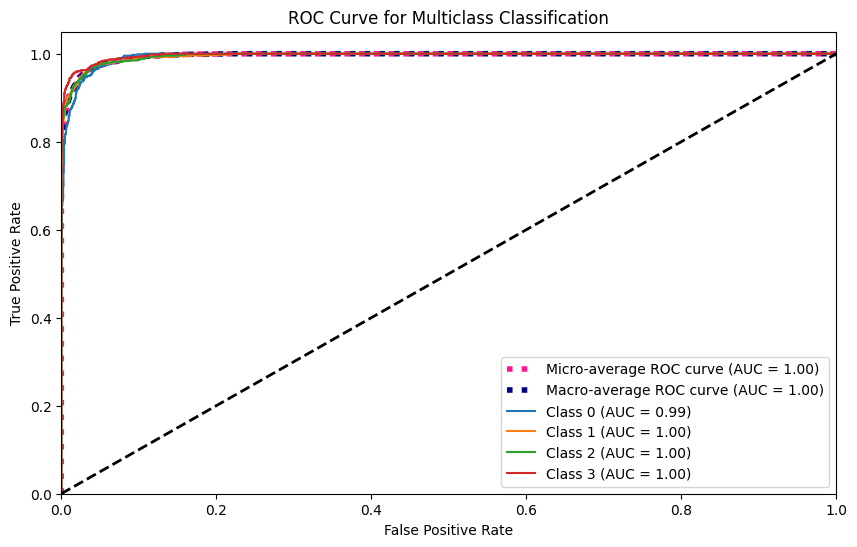

In [24]:
model_name = "Support Vector Machine"  # Evaluación del modelo SVM
model = models[model_name]
y_pred, X_test_transformed, report, cv_results = train_and_evaluate_model(model_name, X_train, X_test, y_train, y_test)

y_pred_probabilities = model.predict_proba(X_test_transformed)
plot_roc_curve_multiclass_from_probabilities(y_test, y_pred_probabilities)

Resultados para K-Nearest Neighbors:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83      3158
         1.0       0.87      0.89      0.88      5024
         2.0       0.89      0.88      0.89      4624
         3.0       0.91      0.89      0.90      3724

    accuracy                           0.87     16530
   macro avg       0.87      0.87      0.87     16530
weighted avg       0.87      0.87      0.87     16530


AUC para el clasificador K-Nearest Neighbors: 0.9848054202211284

Accuracy promedio en K-fold cross-validation: 0.8483536427275084



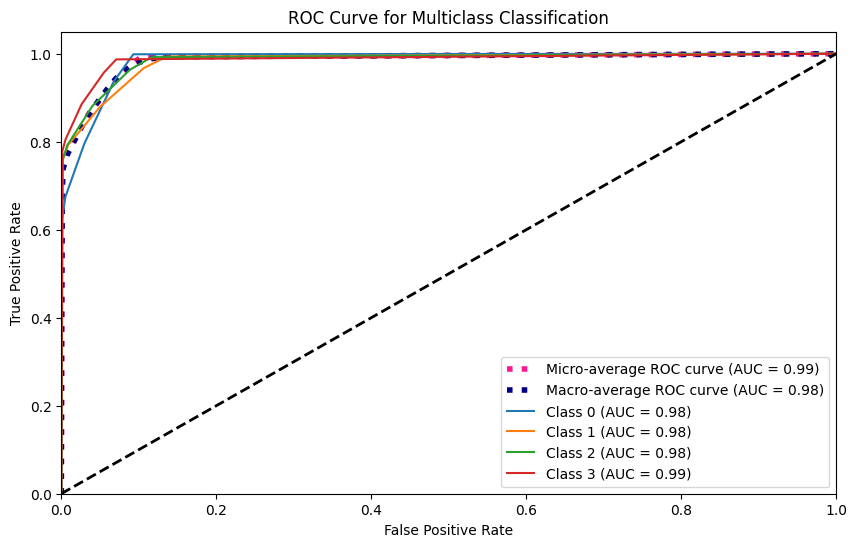

In [23]:
model_name = "K-Nearest Neighbors"  # Evaluación del modelo Knn
model = models[model_name]
y_pred, X_test_transformed, report, cv_results = train_and_evaluate_model(model_name, X_train, X_test, y_train, y_test)

y_pred_probabilities = model.predict_proba(X_test_transformed)
plot_roc_curve_multiclass_from_probabilities(y_test, y_pred_probabilities)